# CLUSTERING WITH NLP: School Uniform edition

### Overview

This clustering project is from the commments of reddit on a opinion saying that school uniforms dont improve child behaviour. 

URL: https://www.reddit.com/r/science/comments/rkmlu2/school_uniforms_dont_improve_child_behavior/

Data: Has over 1.7k comments( in this project, I was only able to get 192 of them, as you need an id to access the full api.)

Goal: To find underlying clusters with unsurpervised learning, meaning finding stuff in common without pretraining them.

Description:
-Imports<br>
-Getting the data<br>
-Cleaning data<br>
-Vectorizing: Using TD-IDF and GloVE<br>
-fitting in a unsupervised clustering model: KMeans<br>
-Interpretation<br>

### Imports

In [1]:
import torch
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Getting the data

In [2]:
r = requests.get('https://www.reddit.com/r/science/comments/rkmlu2/school_uniforms_dont_improve_child_behavior/.json')

In [3]:
r

<Response [200]>

In [4]:
soup = BeautifulSoup(r.content)

In [5]:
text=soup.text

In [6]:
comments=re.findall(r'"body":\s*"([^"]*?)"', text)

In [7]:
#going to create fake user ids just for safety measures
users=[]
for n in range(len(comments)):
    user=f'user{n}'
    users.append(user)    

In [8]:
df=pd.DataFrame(comments, index=users, columns=['comments'])

df

,comments
user0,Welcome to r/science! This is a heavily modera...
user1,Space Jam shirts have been super popular the l...
user2,[removed]
user3,Oof I was a high water kid too. My parents cou...
user4,[deleted]
...,...
user188,"That feels like a very, very surprising findin..."
user189,"My kids go to a public school, where the whole..."
user190,That's maybe more specific to your school. My ...
user191,The selling point of uniforms is that they\u20...


#### Cleaning data/preprocessing

In [9]:
#removing the removed comments
df=df[df['comments']!='[removed]']

In [10]:
#removing the deleted comments
df=df[df['comments']!='[deleted]']

In [11]:
df

,comments
user0,Welcome to r/science! This is a heavily modera...
user1,Space Jam shirts have been super popular the l...
user3,Oof I was a high water kid too. My parents cou...
user5,Wow. Been a while since I heard that word. I g...
user6,"Poor guy, I had the opposite problem. First bo..."
...,...
user188,"That feels like a very, very surprising findin..."
user189,"My kids go to a public school, where the whole..."
user190,That's maybe more specific to your school. My ...
user191,The selling point of uniforms is that they\u20...


In [12]:
#finding any string with url
url_pattern = re.compile(r'https?://\S+')

# Define a function to remove URLs from text
def remove_urls(text):
    return url_pattern.sub('', text)

# Apply the function to the 'text' column and create a new column 'clean_text'
df['comments'] = df['comments'].apply(remove_urls)

In [13]:
df = df.replace(to_replace=r'\d', value='', regex=True)

In [14]:
#replacing unwanted characteristics
replaceDict = dict({
'{':" ", '}':" ", ',':" ", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",'\\n':" ",'\\u':"",'>':"",'r/':""
})

rep = dict((re.escape(k),v) for k, v in replaceDict.items())
pattern = re.compile('|'.join(rep.keys()))
def replacer(text):
    return rep[re.escape(text.group(0))]

df = df['comments'].str.replace(pattern, replacer, regex=True).str.lower()

df= pd.DataFrame(df)

In [15]:
df

,comments
user0,welcome to science this is a heavily moderate...
user1,space jam shirts have been super popular the l...
user3,oof i was a high water kid too my parents cou...
user5,wow been a while since i heard that word i g...
user6,poor guy i had the opposite problem first bo...
...,...
user188,that feels like a very very surprising findin...
user189,my kids go to a public school where the whole...
user190,that s maybe more specific to your school my ...
user191,the selling point of uniforms is that they ure...


#### Clusters with TfidfVectorizer

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['comments'])

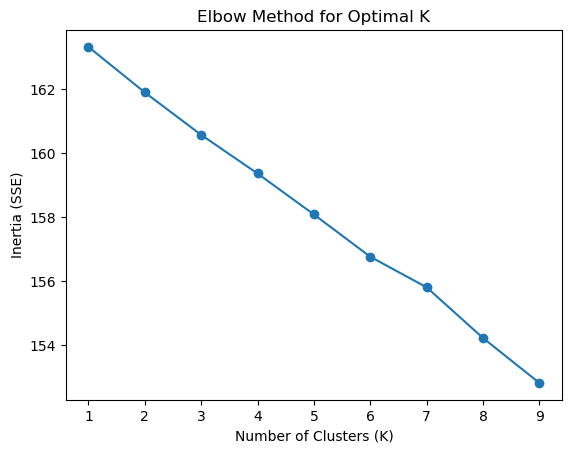

In [18]:
from sklearn.cluster import KMeans
sse = []  # List to store the sum of squared errors (inertia) for each K
for k in range(1, 10):  # Testing K values from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    sse.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method for Optimal K')
plt.show()

In [19]:
kmeans2 = KMeans(n_clusters=5, random_state=42)
kmeans2.fit(tfidf_matrix)

KMeans(n_clusters=5, random_state=42)

In [20]:
from sklearn.decomposition import PCA

pca = PCA(2)

words=pca.fit_transform(tfidf_matrix)

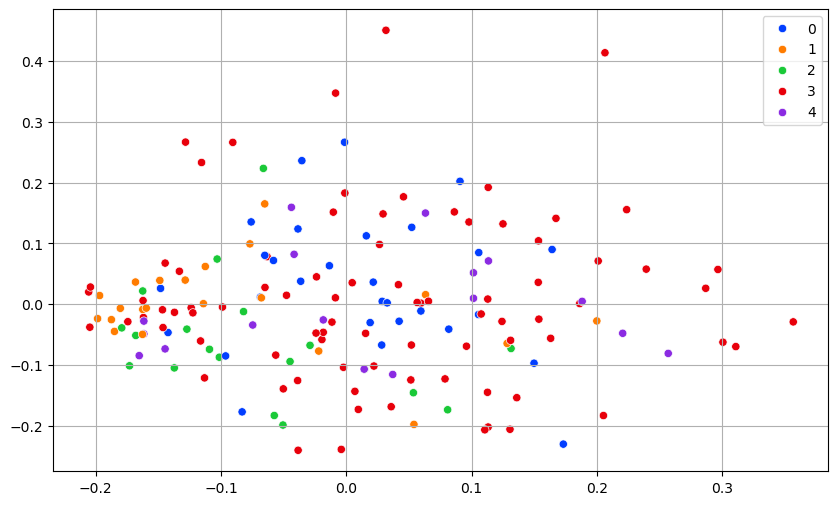

In [21]:
plt.figure(figsize=(10,6))
plt.grid(True)
sns.scatterplot(x=words[:,0],y=words[:,1],hue=kmeans2.labels_, palette='bright')
plt.legend(loc="upper right")
plt.show()

We can see her that there isnt much of a clustering pattern to distinguish, so we will try to use a different vectorization method

#### Clustering with GloVE embeddings

In [22]:
# need to split the sentences
words = df['comments'].str.split()
words = pd.DataFrame(words.tolist())
words

,0,1,2,3,4,5,6,7,8,9,...,373,374,375,376,377,378,379,380,381,382
0,welcome,to,science,this,is,a,heavily,moderated,subreddit,in,...,None,None,None,None,None,None,None,None,None,None
1,space,jam,shirts,have,been,super,popular,the,last,years,...,None,None,None,None,None,None,None,None,None,None
2,oof,i,was,a,high,water,kid,too,my,parents,...,None,None,None,None,None,None,None,None,None,None
3,wow,been,a,while,since,i,heard,that,word,i,...,None,None,None,None,None,None,None,None,None,None
4,poor,guy,i,had,the,opposite,problem,first,born,so,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,that,feels,like,a,very,very,surprising,finding,n,ni,...,None,None,None,None,None,None,None,None,None,None
166,my,kids,go,to,a,public,school,where,the,whole,...,None,None,None,None,None,None,None,None,None,None
167,that,s,maybe,more,specific,to,your,school,my,uniforms,...,None,None,None,None,None,None,None,None,None,None
168,the,selling,point,of,uniforms,is,that,they,ure,cheap,...,None,None,None,None,None,None,None,None,None,None


In [24]:
#import model
import gensim.downloader as model_api
word_vectors = model_api.load("glove-wiki-gigaword-50")

In [25]:
# Function to retrieve the word vector or return a zero vector if the word is not found
def get_word_vector(word):
    if word in word_vectors:
        return word_vectors[word]
    else:
        return np.zeros(word_vectors.vector_size)

# Function to map a review to its vector representation
def map_review_to_vector(review):
    vectors = [get_word_vector(word) for word in review if pd.notna(word)]
    if vectors:  # Check if list is not empty
        return np.mean(vectors, axis=0)  # Average for normalization
    else:
        return np.zeros(word_vectors.vector_size)

# Applying the mapping function to each review and create a DataFrame of the results
emb = pd.DataFrame(words.apply(map_review_to_vector, axis=1).tolist())

emb

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.392602,0.148077,-0.017871,-0.100151,0.354204,0.057617,-0.292076,-0.096907,-0.180560,-0.036049,...,-0.072038,0.023022,0.024093,0.303041,-0.004213,0.078171,-0.111622,0.225430,-0.071681,0.084979
1,0.224076,0.123353,0.054138,0.104306,0.071046,0.021270,-0.727000,-0.341376,-0.229989,0.031614,...,-0.274072,0.158726,-0.115124,0.272508,0.064276,0.099303,-0.361136,-0.311205,-0.244362,-0.219781
2,0.003975,0.205879,-0.016613,-0.413304,0.415406,0.029522,-0.435736,-0.091512,-0.133187,0.105707,...,-0.151010,0.131525,0.040550,0.404125,0.085325,-0.188519,-0.041552,-0.481508,0.073337,0.160419
3,0.265242,0.064165,-0.039162,-0.212511,0.451037,-0.053917,-0.498389,0.060593,-0.232092,0.050927,...,-0.210784,0.046729,-0.096777,0.249146,-0.008726,0.058009,-0.129835,-0.034118,-0.104034,0.113582
4,0.089169,0.114412,-0.058184,-0.363811,0.317448,0.200549,-0.441683,-0.094954,-0.262609,-0.054432,...,-0.244876,0.096426,-0.016006,0.198526,0.004228,-0.055924,-0.035932,-0.331503,-0.061560,0.048522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,0.300636,0.191008,-0.020336,-0.048356,0.459477,0.219379,-0.185881,-0.268628,-0.128671,0.018203,...,-0.089585,0.081590,-0.000060,0.162076,-0.016328,0.060269,-0.106981,-0.001898,0.061693,0.144554
166,0.130466,0.335869,-0.094524,-0.260881,0.573105,0.049936,-0.540578,-0.187052,-0.082085,-0.165662,...,-0.240473,0.001737,0.009465,0.182786,-0.111095,0.043098,-0.059935,-0.179005,0.029081,0.039751
167,0.245515,0.197416,0.066546,-0.280719,0.390769,0.189540,-0.492748,-0.322764,-0.138144,-0.000381,...,-0.152172,0.053506,0.248623,0.292503,0.043433,-0.056319,-0.211752,-0.152458,-0.099554,0.056670
168,0.127029,0.218344,0.009281,-0.238793,0.419856,0.147012,-0.359019,-0.356831,-0.103076,-0.068907,...,-0.071803,0.058330,0.023513,0.240697,0.002388,-0.105104,0.038282,-0.085342,-0.013034,0.116469


C:\Users\Administrator\Documents\python\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Administrator\Documents\python\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Administrator\Documents\python\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Administrator\Documents\python\envs\env\lib\site-packag

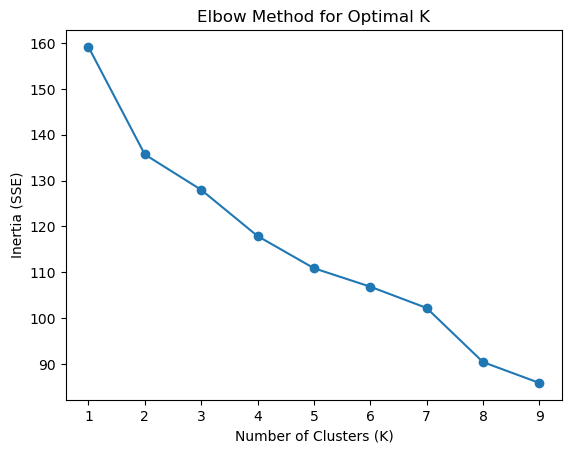

In [26]:
from sklearn.cluster import KMeans
sse = []  # List to store the sum of squared errors (inertia) for each K
for k in range(1, 10):  # Testing K values from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(emb)
    sse.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method for Optimal K')
plt.show()

In [27]:
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(emb)

C:\Users\Administrator\Documents\python\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(random_state=42)

In [28]:
from sklearn.decomposition import PCA

pca = PCA(2)

words=pca.fit_transform(emb)

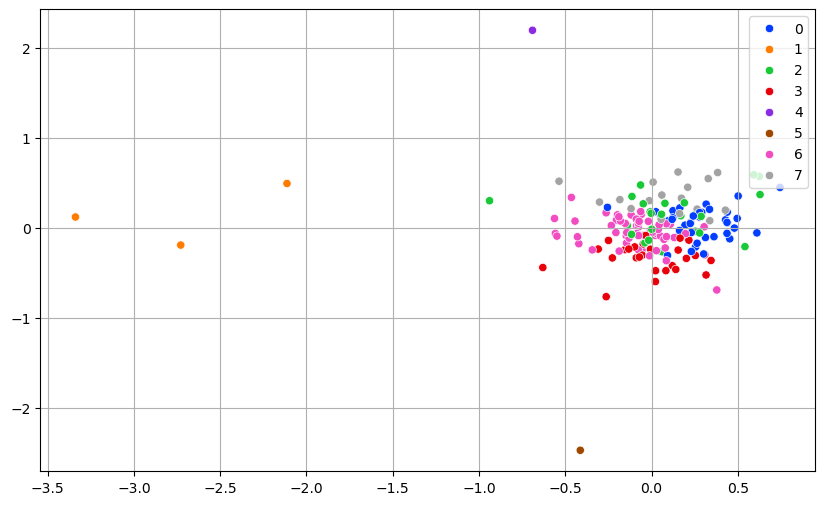

In [29]:
plt.figure(figsize=(10,6))
plt.grid(True)
sns.scatterplot(x=words[:,0],y=words[:,1],hue=kmeans.labels_, palette='bright')
plt.legend(loc="upper right")
plt.show()

In [30]:
df['Cluster']=kmeans.labels_

In [31]:
df.head()

,comments,Cluster
user0,welcome to science this is a heavily moderate...,2
user1,space jam shirts have been super popular the l...,6
user3,oof i was a high water kid too my parents cou...,7
user5,wow been a while since i heard that word i g...,0
user6,poor guy i had the opposite problem first bo...,0


#### Interpretations

In the second model, we are actually able to see some clustering. Let us see what these sentences have in common

In [33]:
#In dataframe, we cant see the full sentences
comments

['Welcome to r/science! This is a heavily moderated subreddit in order to keep the discussion on science. However, we recognize that many people want to discuss how they feel the research relates to their own personal lives, so to give people a space to do that, **personal anecdotes are now allowed as responses to this comment**. Any anecdotal comments elsewhere in the discussion will continue be removed and our [normal comment rules]( https://www.reddit.com/r/science/wiki/rules#wiki_comment_rules) still apply to other comments.\\n\\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/science) if you have any questions or concerns.*',
 'Space Jam shirts have been super popular the last 3 years or so.',
 '[removed]',
 'Oof I was a high water kid too. My parents could never buy the right size pants.',
 '[deleted]',
 "Wow. Been a while since I heard that word. I got the same thing all the time because getting 

In [34]:
df[df['Cluster']==0]

,comments,Cluster
user5,wow been a while since i heard that word i g...,0
user6,poor guy i had the opposite problem first bo...,0
user29,i wished my school had uniforms i could never...,0
user44,agree my daughter started school this yea...,0
user45,my kids miss their uniform they didn t know b...,0
user53,that s how it is here i live in the us and th...,0
user54,the argument i heard against this in south kor...,0
user59,agreed working in a hospital where i had to w...,0
user60,i had uniforms at my american school it was g...,0
user61,growing up in australia where practically eve...,0


For cluster 0, the common theme that they had was cheap and expensive clothing words. So some examples was goodwill, and saving money, and some buying from rich places.

In [36]:
df[df['Cluster']==1]

,comments,Cluster
user55,the average price of catholic and independent ...,1
user124,,1
user184,__ laughs in australian __,1


For cluster 1, I dont really know its connection other than there was special characters I forgot to remove.

In [37]:
df[df['Cluster']==2]

,comments,Cluster
user0,welcome to science this is a heavily moderate...,2
user16,i am most creative when restrictions are place...,2
user26,they re subjective to perspective and mood it...,2
user46,op at bottom n nedit wow i did not expect ...,2
user52,why is school spirit such a big deal n ni ve ...,2
user66,how did the word,2
user71,well public is the traditional british nome...,2
user78,fashion was one of those things here in the s ...,2
user83,yeah it s just your typical highly visible and...,2
user90,i m guessing the thought is that intruders pro...,2


For cluster 2, the main theme was the mindset, their emotions, their behaviour, anything related to their personality.

In [38]:
df[df['Cluster']==3]

,comments,Cluster
user15,that us not counter intuitive at all most cre...,3
user31,user error vs hardware error crap quality and...,3
user38,i went to a private school for all of k where...,3
user40,this i went from no uniforms k to uniforms...,3
user49,or very expensive phones,3
user56,it should be contextualised for the non austra...,3
user57,in australia you can tell which kids are rich ...,3
user62,oh i worked it out but i always refer to stat...,3
user63,chalk it up to the british to define public as,3
user64,edit uca public school in england and wales ...,3


Cluster 3 all have intense words, such as negative words, and exagerated words

In [39]:
df[df['Cluster']==4]

,comments,Cluster
user48,oh yeah i m old,4


In [40]:
df[df['Cluster']==5]

,comments,Cluster
user87,security guard,5


In [42]:
df[df['Cluster']==6]

,comments,Cluster
user1,space jam shirts have been super popular the l...,6
user11,i agree with your daughter all my school s ha...,6
user21,spend time picking out an outfit each day n ni...,6
user28,this reminds me of the boys in the uk being de...,6
user30,i went to a canadian catholic high school in t...,6
user33,then your uniforms sucked n ni went to both ...,6
user34,i absolutely hated uniforms all the way to th...,6
user36,i had to wear a uniform from th th grade and a...,6
user37,completely agree changed schools from no uni...,6
user39,it took the obvious wealthy poor factor out o...,6


CLuster 6 had specific clothes words, such as shirts, turtle neck, shorts, etc. Also talked about sense of fashion

In [44]:
df[df['Cluster']==7]

,comments,Cluster
user3,oof i was a high water kid too my parents cou...,7
user12,i m the opposite i hate having clothes inside...,7
user27,when from no uniform to no uniforms but very s...,7
user35,polo shirts still make me feel gross inside i...,7
user50,same in our country you get your uniform from...,7
user80,when i was a kid we didn t have uniforms but...,7
user91,they look at you with a vacant glassy eyed sta...,7
user98,or just not having enough uniforms so they end...,7
user100,what jackasses not cool my son broke his arn...,7
user103,you can still tell easily i dropped my kid o...,7


Cluster 7 had words that describe mess and dirt